In [10]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from scipy import stats

%matplotlib inline

In [15]:
con = sqlite3.connect('immobilienscout24.db')
cur=con.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

full_data = pd.read_sql_query('SELECT * from full_data', con)
full_data = full_data.drop(columns="index")
full_data.head()

,address,kaltmiete,sq_m,rooms,id,district
0,"Stallschreiberstraße 31, Mitte (Mitte), Berlin",1099.000000,56.500000,2.0,115477798,Mitte
1,"Danziger Straße 73, Prenzlauer Berg (Prenzlaue...",1459.000000,75.019997,2.0,113885749,Prenzlauer Berg
2,"Schkeuditzer Str. 30, Hellersdorf (Hellersdorf...",734.520020,71.660004,3.0,115694327,Hellersdorf
3,"Regattastraße 29, Grünau (Köpenick), Berlin",1050.189941,79.559998,2.0,115687131,Köpenick
4,"Gaffelsteig 3, Schmöckwitz (Köpenick), Berlin",1114.339966,84.269997,3.0,114910296,Köpenick


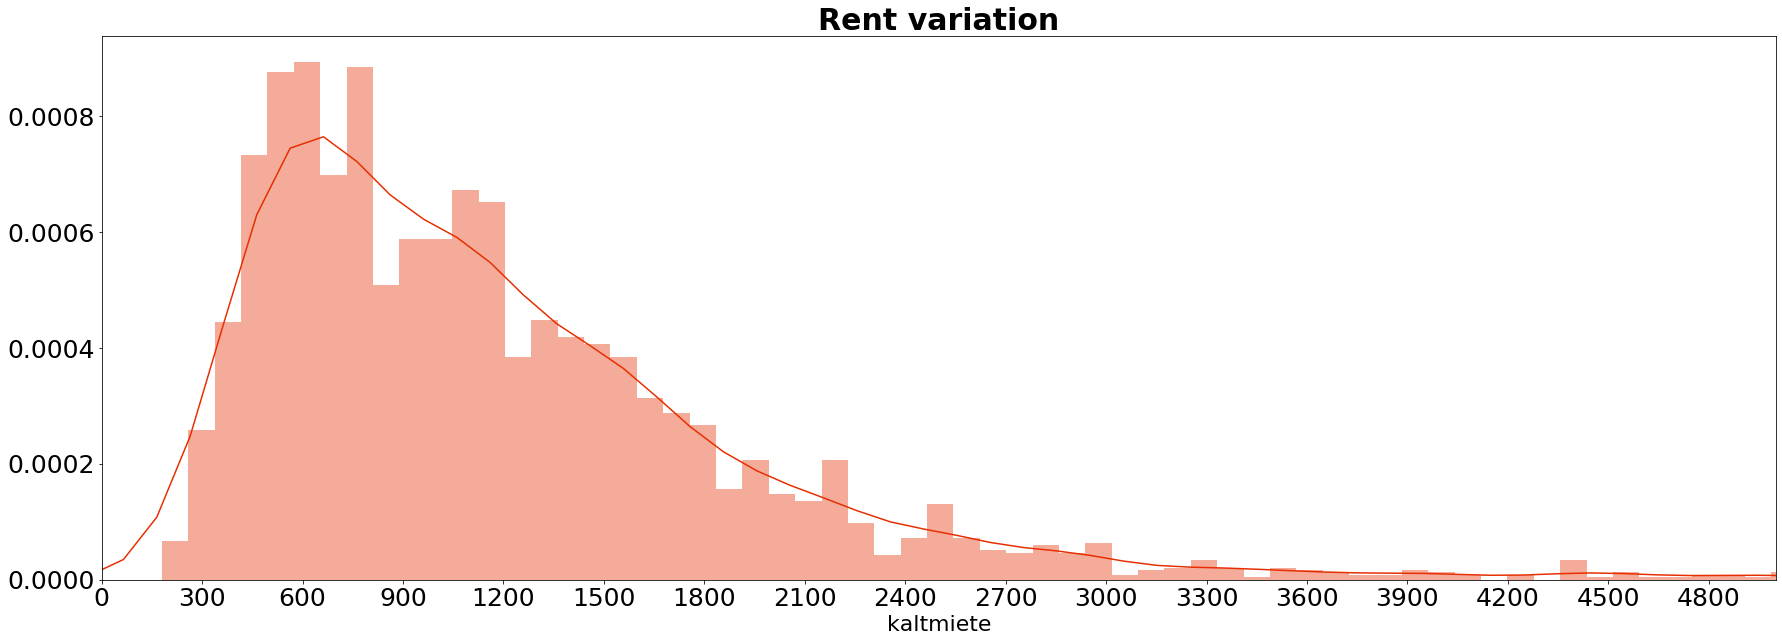

In [11]:
rcParams['figure.figsize'] = 30, 10
plt.rcParams.update({'font.size': 22})

sns.distplot(full_data['kaltmiete'], 150, color='#e62e00')
plt.xlim(0,5000)
plt.title("Rent variation",fontsize=30, fontweight='bold')
plt.tick_params(axis='both', labelsize=25)
plt.xticks(np.arange(0, 5000, 300))
plt.show()

Text(0.5, 1.0, 'Number of apartments to rent by number of rooms')

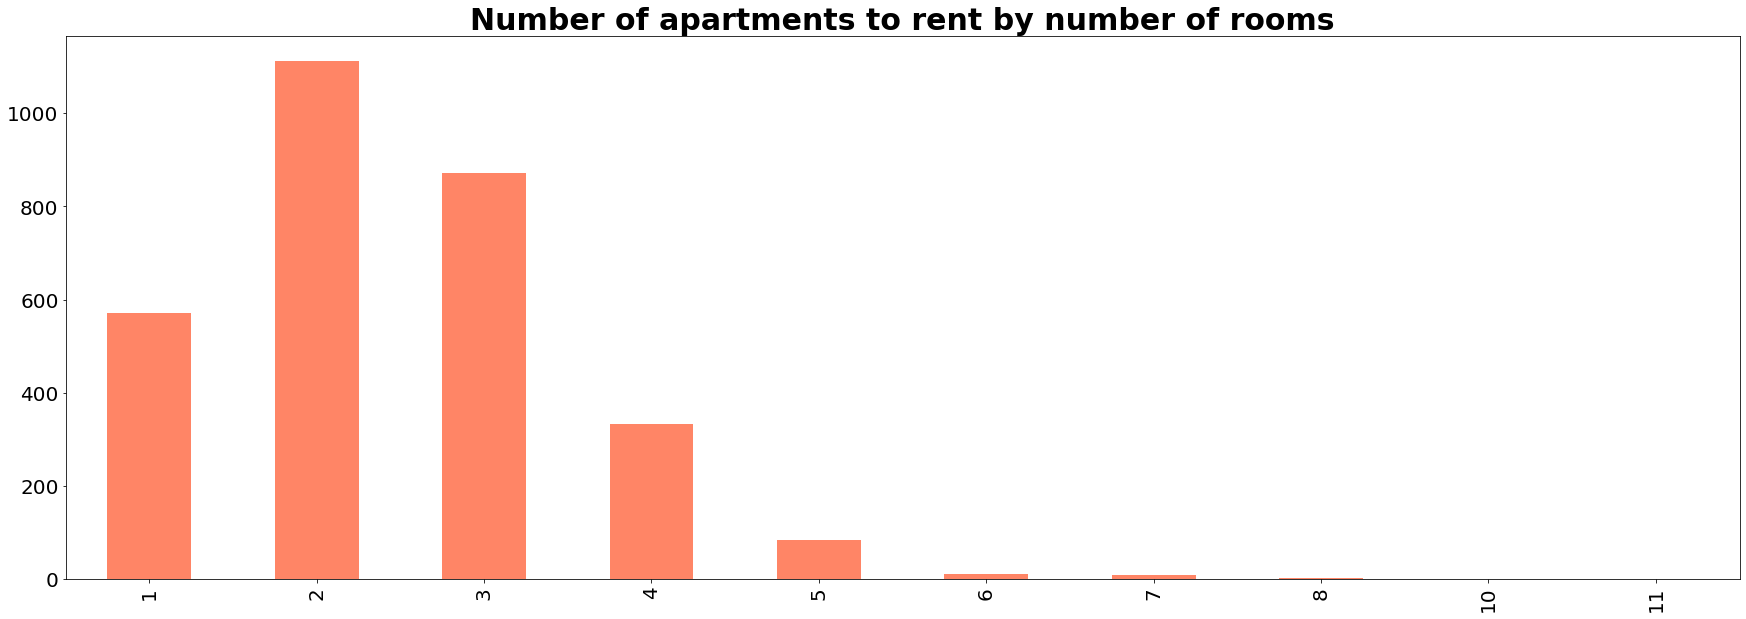

In [12]:
n_rooms_plot=full_data['rooms'].astype(np.int32).value_counts().sort_index().plot(kind='bar', fontsize=20, color='#ff8566')
n_rooms_plot.set_title('Number of apartments to rent by number of rooms', fontsize=30, fontweight='bold')

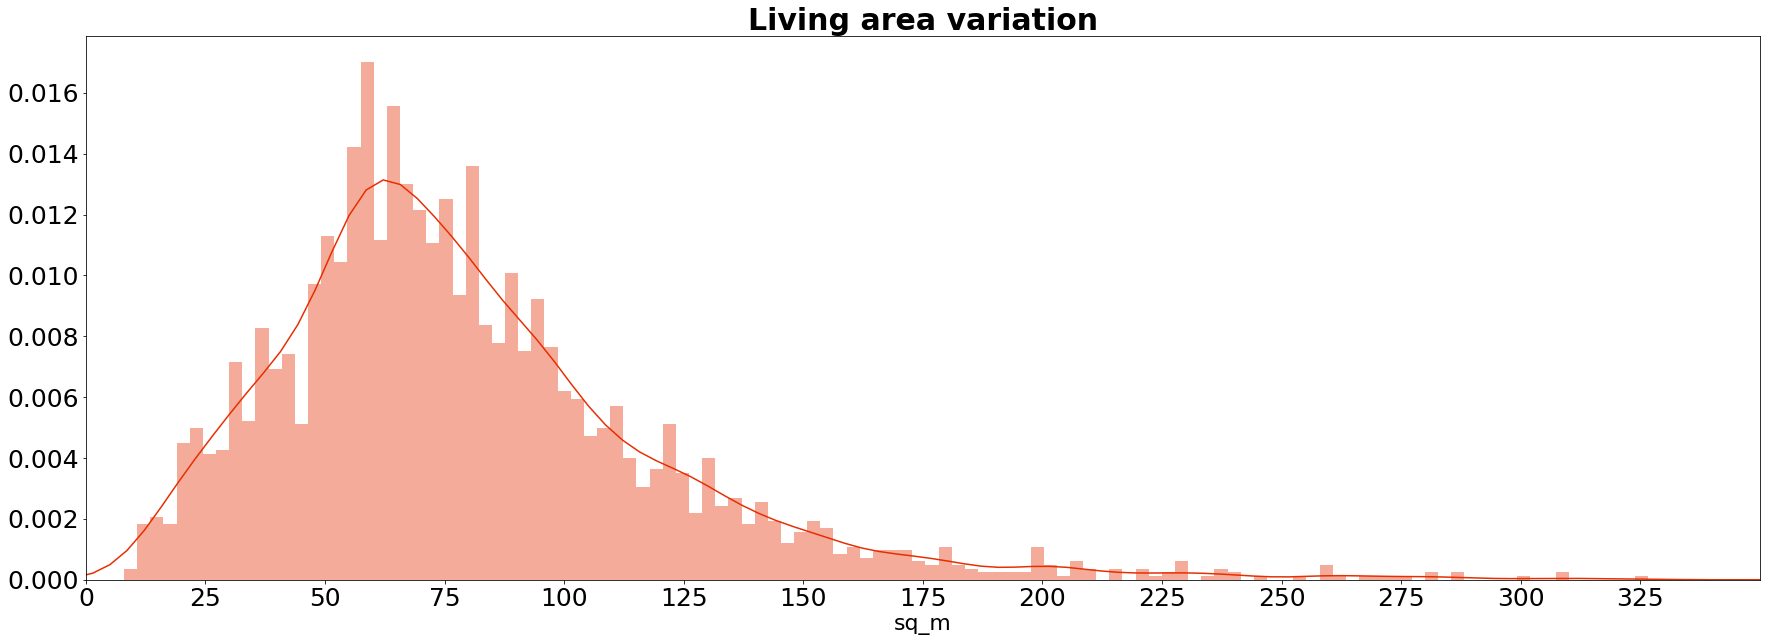

In [13]:
rcParams['figure.figsize'] = 30, 10
sns.distplot(full_data['sq_m'], 150, color='#e62e00')
plt.xlim(0,350)
plt.title("Living area variation",fontsize=30, fontweight='bold')
plt.tick_params(axis='both', labelsize=25)
plt.xticks(np.arange(0, 350, 25))
plt.show()

Text(0.5, 1.0, 'Number of apartments to rent by districts')

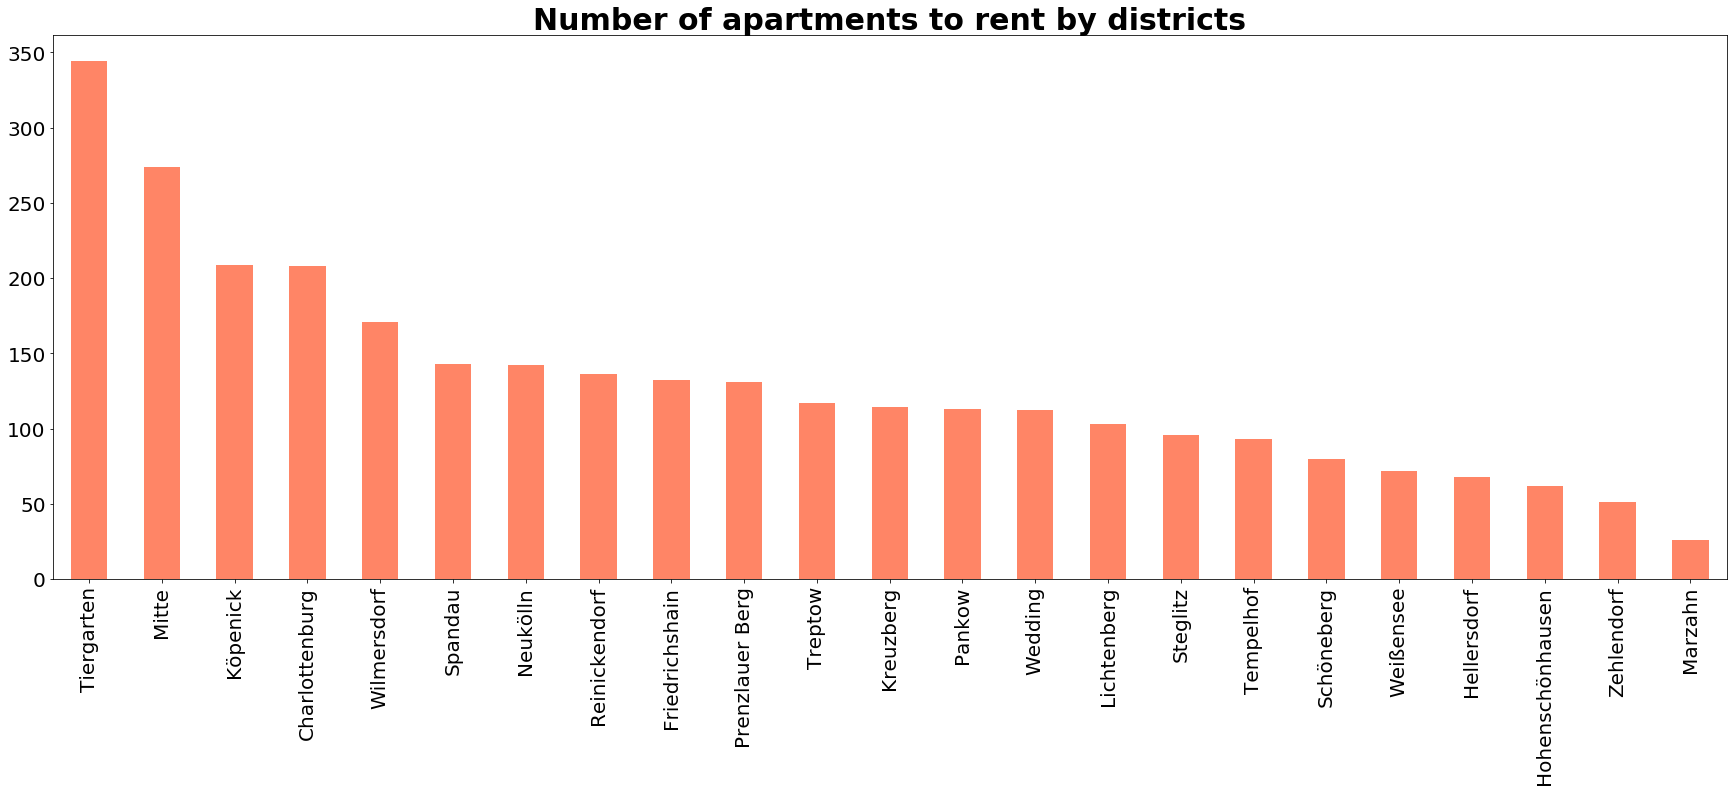

In [16]:
distr_plot=full_data['district'].value_counts().plot(kind='bar', fontsize=20, color='#ff8566')
distr_plot.set_title('Number of apartments to rent by districts', fontsize=30, fontweight='bold')

Text(0.5, 1.0, 'Median rent by districts')

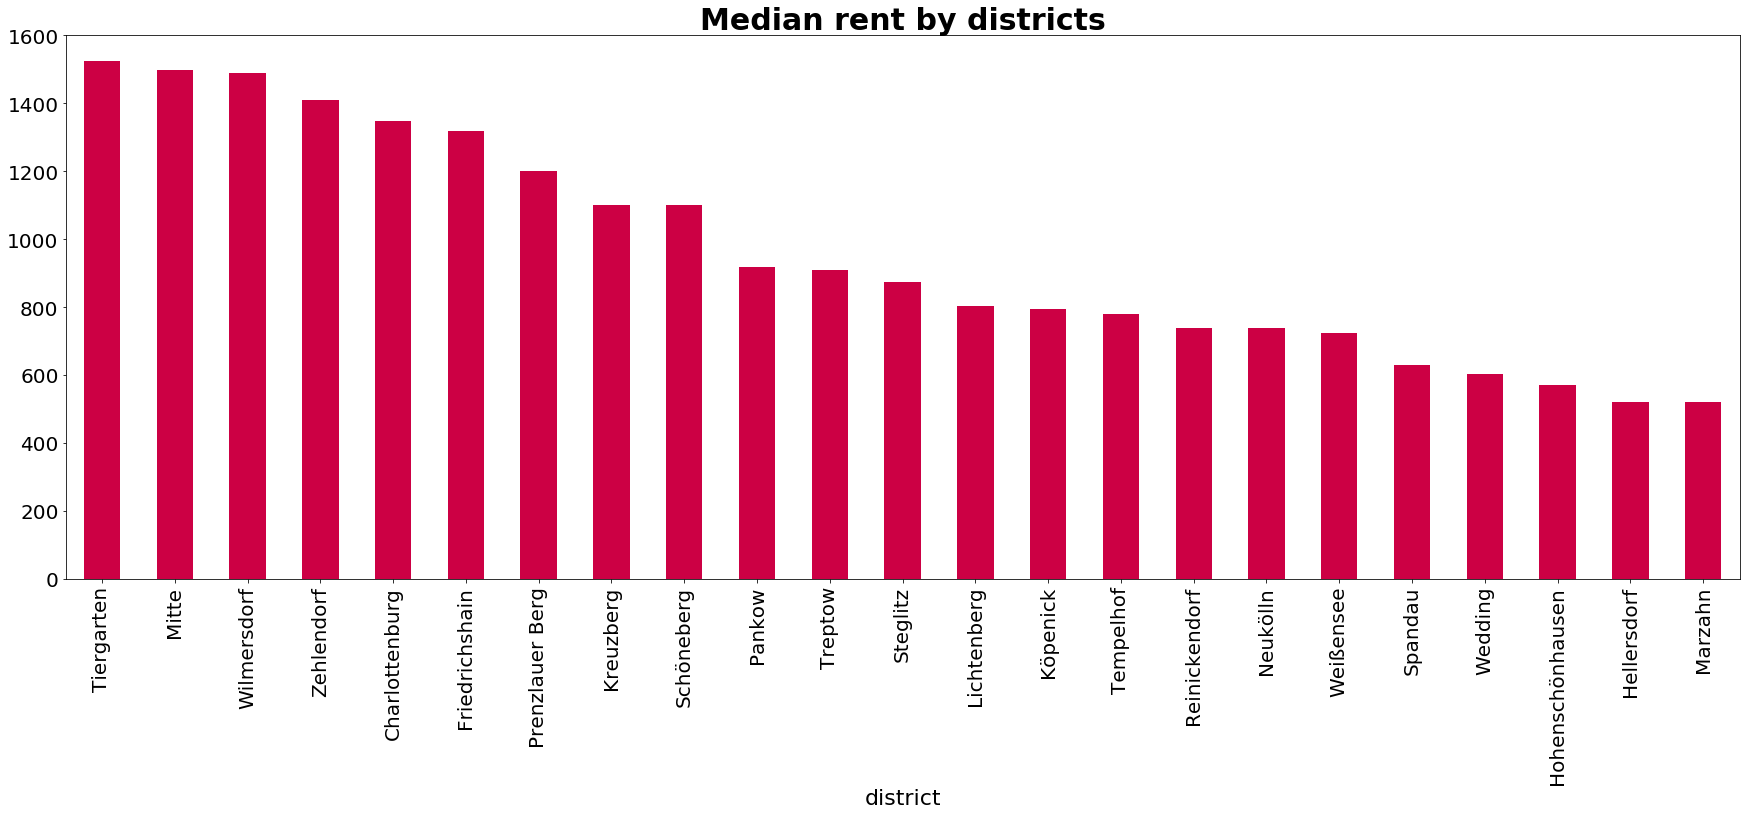

In [17]:
mean_km=full_data['kaltmiete'].groupby(full_data['district']).median().sort_values(ascending=False).plot(kind='bar', fontsize=20, color='#cc0044')
mean_km.set_title('Median rent by districts', fontsize=30, fontweight='bold')

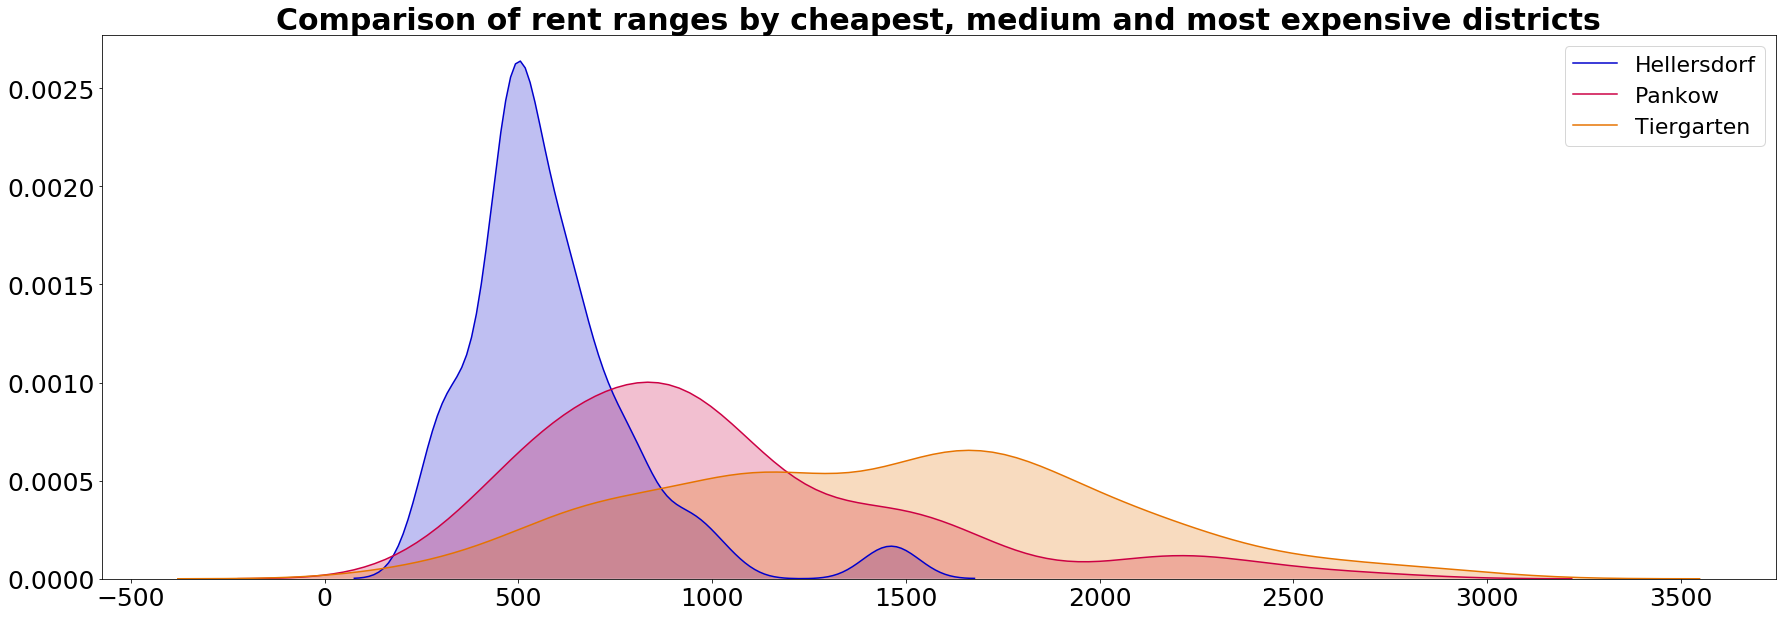

In [34]:
sns.kdeplot(full_data.loc[full_data['district']=='Hellersdorf', 'kaltmiete'], 
            label='Hellersdorf', shade=True, color='#0000cc')
sns.kdeplot(full_data.loc[full_data['district']=='Pankow', 'kaltmiete'],
            label='Pankow', shade=True, color='#cc0044')
sns.kdeplot(full_data.loc[(full_data['district']=='Tiergarten') & (full_data['kaltmiete']<3000), 'kaltmiete'],
            label='Tiergarten', shade=True, color='#e67300')
plt.title("Comparison of rent ranges by cheapest, medium and most expensive districts",fontsize=30, fontweight='bold')
plt.tick_params(axis='both', labelsize=25)
plt.show()

			Joint distribution of living area and kalmiete


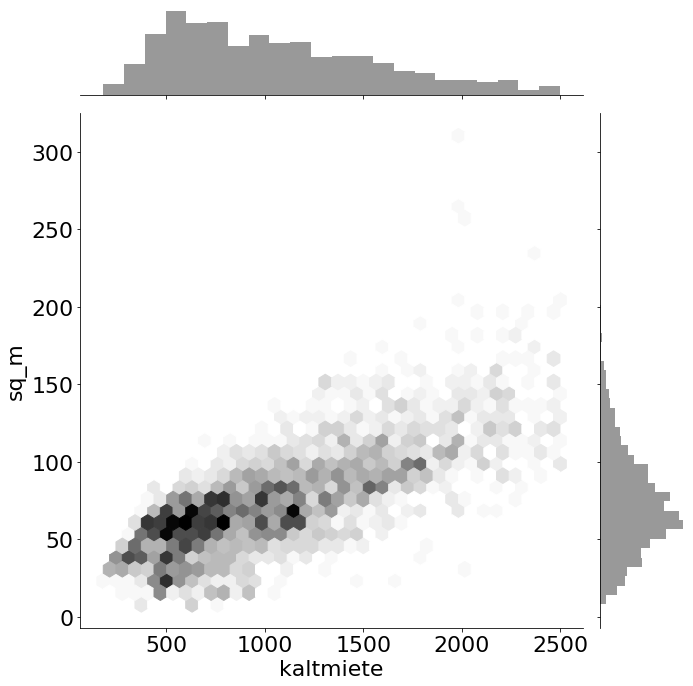

In [27]:
sns.jointplot(x=full_data[full_data['kaltmiete']<2500]['kaltmiete'],y=full_data[full_data['kaltmiete']<2500]['sq_m'], kind="hex", color="k", size=10)
print('\t\t\tJoint distribution of living area and kalmiete')

In [66]:
regr_data=pd.get_dummies(full_data, columns=['district'])
X=regr_data.drop(['address', 'kaltmiete', 'id'], axis=1)
col_names=X.columns.tolist()
X.head()

,sq_m,rooms,district_Charlottenburg,district_Friedrichshain,district_Hellersdorf,district_Hohenschönhausen,district_Kreuzberg,district_Köpenick,district_Lichtenberg,district_Marzahn,...,district_Schöneberg,district_Spandau,district_Steglitz,district_Tempelhof,district_Tiergarten,district_Treptow,district_Wedding,district_Weißensee,district_Wilmersdorf,district_Zehlendorf
0,56.500000,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,75.019997,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,71.660004,3.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,46.740002,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,79.559998,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
Y=regr_data['kaltmiete']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=3)

Minimum cross_val_score: 176876.01928632008
Alpha for minimum cross_val_score: 1.0


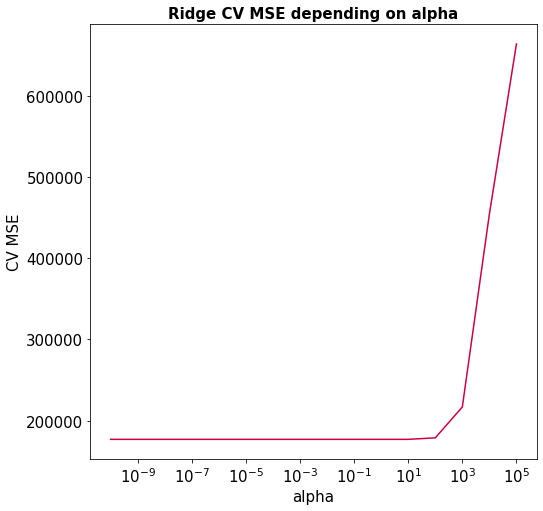

In [68]:
alpha_list = np.logspace(-10,5,16)
k_scores = [-cross_val_score(Ridge(alpha=alpha), X, Y, cv=5, scoring='neg_mean_squared_error').mean() for alpha in alpha_list]
print('Minimum cross_val_score:',k_scores[np.argmin(k_scores)])
opt_alpha=alpha_list[np.argmin(k_scores)]
print('Alpha for minimum cross_val_score:',opt_alpha)

rcParams['figure.figsize'] = 8,8
plt.semilogx(alpha_list, k_scores, color='#cc0044')
plt.xlabel("alpha", size=15)
plt.ylabel("CV MSE", size=15)
plt.title('Ridge CV MSE depending on alpha', fontsize=15, fontweight='bold')
plt.tick_params(axis='both', labelsize=15)

In [69]:
rr=Ridge(alpha=opt_alpha)
rr.fit(X_train, Y_train)
Y_pr=rr.predict(X_test)
Ridge_test_score=mean_squared_error(Y_test, Y_pr)
print('Mean squared error:',Ridge_test_score)

Mean squared error: 133755.9510874887


Text(0.5, 1.0, 'Coefficient values')

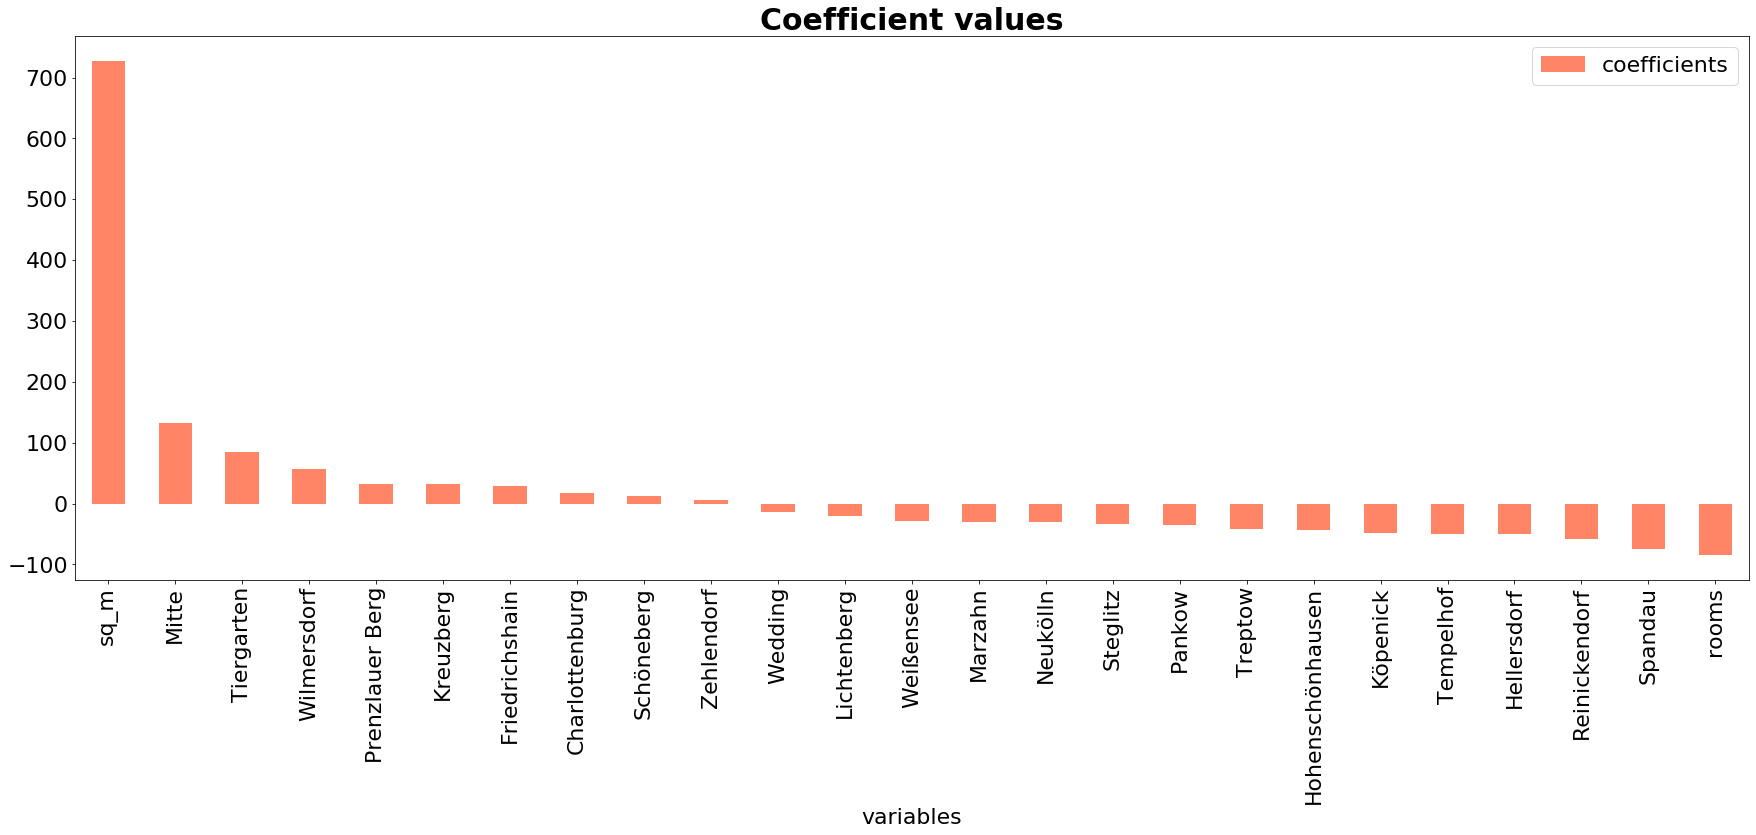

In [70]:
variables=[]
for i in col_names:
    if len(i)>5:
        variables.append(i.split('_')[1])
    else:
        variables.append(i)
coef=pd.DataFrame({'variables':variables, 'coefficients':rr.coef_})
rcParams['figure.figsize'] = 30, 10
coef.sort_values(by='coefficients', ascending=False).plot.bar('variables','coefficients', color='#ff8566')
plt.title('Coefficient values', fontsize=30, fontweight='bold')

In [71]:
cv_predicted=cross_val_predict(rr, X, Y, cv=5)
prices_cv=pd.DataFrame({'Y_fact':Y, 'Y_pr_cv':cv_predicted})
prices_cv=prices_cv[prices_cv['Y_fact']<4000]
prices_cv=prices_cv[prices_cv['Y_pr_cv']<4000]
prices_cv.head()

,Y_fact,Y_pr_cv
0,1099.000000,1284.464204
1,1459.000000,1292.780000
2,734.520020,700.980371
3,429.540009,376.418028
4,1050.189941,1025.687331


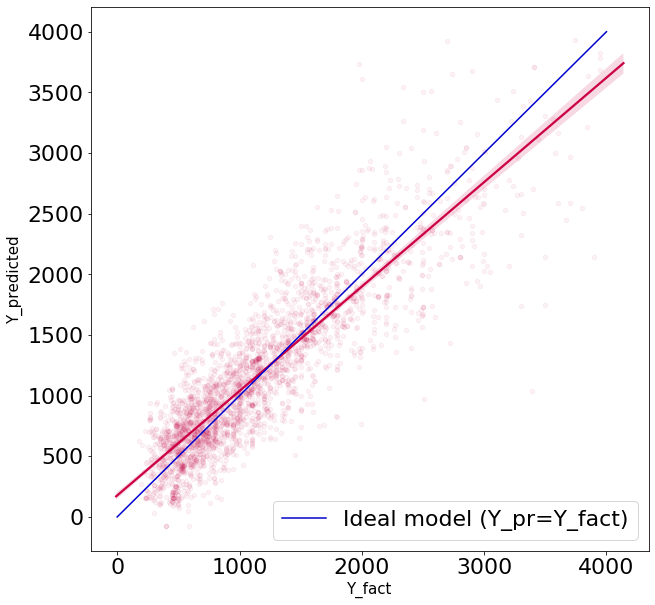

In [72]:
rcParams['figure.figsize'] = 10, 10
sns.regplot(prices_cv['Y_fact'], prices_cv['Y_pr_cv'], scatter_kws={'alpha':0.05, 's':20}, color='#cc0044')
plt.plot([0,4000],[0,4000], color='#0000cc', label='Ideal model (Y_pr=Y_fact)')
plt.legend()
plt.xlabel('Y_fact', size=15)
plt.ylabel('Y_predicted', size=15)
plt.show()

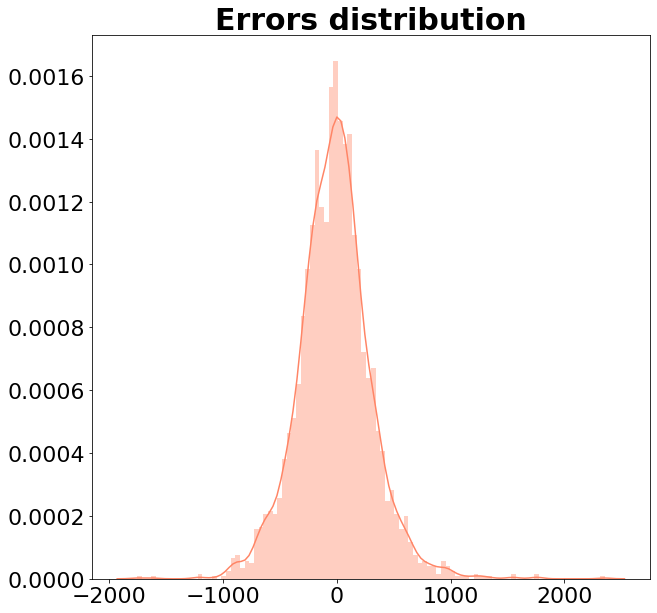

In [73]:
sns.distplot(prices_cv['Y_fact']-prices_cv['Y_pr_cv'], 100, color='#ff8566')
plt.title("Errors distribution",fontsize=30, fontweight='bold')
plt.show()

In [74]:
k2,p=stats.normaltest(prices_cv['Y_fact']-prices_cv['Y_pr_cv'])
alpha=0.1
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Errors do not come from normal distribution")
else:
    print("Errors come from normal distribution")

Errors do not come from normal distribution
